### 1 Un problème de programmation linéaire 

**Q1.2**

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import linprog 

In [396]:
def solve0T(mu,nu,C):
    N=len(mu)
    C=C.reshape((N*N,))
    b=np.concatenate((mu,nu))
    A=def_A(N)
    x=linprog(C,A_eq=A,b_eq=b,method='interior-point').x
    return x
    
    
def def_A(N):
    A=np.array([1 if j in np.arange(1+(i-1)*(N),N+(i-1)*(N)+1) else 0 for i in np.arange(1,2*N+1) for j in np.arange(1,N*N+1)]).reshape((2*N,N*N))
    A[N:2*N+1,:]=np.array([1 if j in np.arange(i,i+N*N+1,N) else 0 for i in np.arange(1,N+1) for j in np.arange(1,N*N+1)]).reshape((N,N*N))
    return A


**Q1.3**

In [326]:
N=20
x=np.linspace(0,1,N)
y=np.linspace(0,1,N)
mu=np.ones(len(x))/N
nu=np.exp(-10*(y-0.5)**2)
nu=nu/sum(nu)
C=np.array([(i-j)**2 for i in x for j in y]).reshape(N,N)
gamma=solve0T(mu,nu,C)

Text(0.5, 1.0, 'Courbe de niveau de gamma')

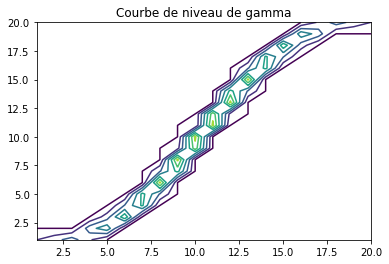

In [327]:
I,J=np.meshgrid(np.arange(1,N+1),np.arange(1,N+1))
gamma=gamma.reshape((N,N))
plt.contour(I,J,gamma)
plt.title("Courbe de niveau de gamma")

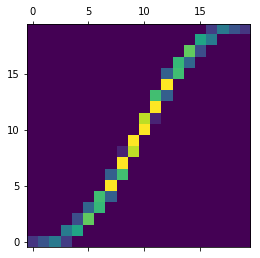

In [328]:
plt.matshow(gamma,origin='lower')

**Q1.4**

In [397]:
def solve0Tdual(mu,nu,C):
    N=len(mu)
    C=C.reshape((N*N,))
    b=np.concatenate((mu,nu))
    AT=def_A(N).T
    uv=linprog(-b,A_ub=AT,b_ub=C,bounds=(None,None),method='interior-point').x
    s=C-np.dot(AT,uv) # variable d'écart
    return [uv[:N],uv[N:],s]

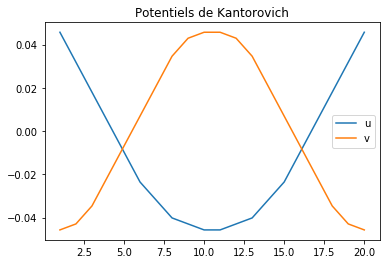

In [390]:
ue,ve,s=solve0Tdual(mu,nu,C)
plt.plot(np.arange(1,N+1),ue)
plt.plot(np.arange(1,N+1),ve)
plt.title("Potentiels de Kantorovich")
plt.legend(("u","v"))

Vérifions que $x_{i}^{*}s_{i} = 0$ $\forall i =1,...,N$ où $x^{*}$ est la solution du problème primal

In [15]:
gamma=solve0T(mu,nu,C)
all(gamma*s<=10**(-8))

True

**Q1.5**

In [366]:
N=20
x=np.random.rand(N)
y=np.random.randn(N)
mu=np.ones(N)/N
nu=np.ones(N)/N
C=np.array([(i-j)**2 for i in x for j in y]).reshape(N,N)
gamma=solve0T(mu,nu,C).reshape((N,N))

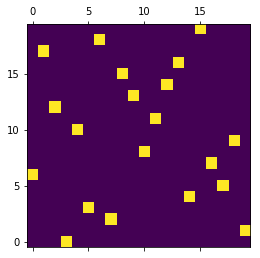

In [367]:
plt.matshow(gamma,origin='lower')

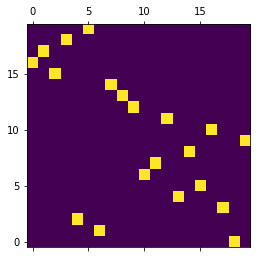

In [383]:
N=20
x=np.random.rand(N,2)
y=np.random.randn(N,2)
mu=np.ones(N)/N
nu=np.ones(N)/N
C=np.array([sum((i-j)**2) for i in x for j in y]).reshape(N,N)
gamma=solve0T(mu,nu,C).reshape((N,N))
plt.matshow(gamma,origin='lower')

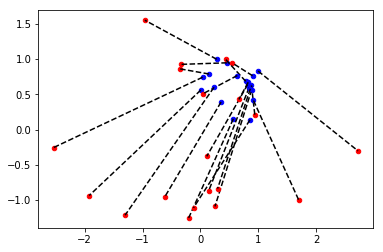

In [384]:
I=np.arange(1,N+1)
J=np.arange(1,N+1)
sigma=[[i,J[gamma[i-1]>10**(-8)][0]] for i in I]
for [i,j] in sigma :
    plt.plot(x[i-1,0],x[i-1,1],'b',marker='.',markerSize=9)
    plt.plot(y[j-1,0],y[j-1,1],'r',marker='.',markerSize=9)
    plt.plot([x[i-1,0],y[j-1,0]],[x[i-1,1],y[j-1,1]],'--k')

### 2 Le problème dual et la fonction log-sum-exp

In [118]:
def GradDualReg(mu,nu,C,eps,t,tol,iterMax):
    N=len(mu)
    u=np.zeros(N)
    k=0
    d=mu-np.sum([nu[j]*(np.exp((u-C[:,j])/eps)/np.sum(np.exp((u-C[:,j])/eps))) for j in np.arange(0,N)],axis=0)
    while np.linalg.norm(d)>eps and k<iterMax:
        u=u+t*d
        d=mu-np.sum([nu[j]*(np.exp((u-C[:,j])/eps)/np.sum(np.exp((u-C[:,j])/eps))) for j in np.arange(0,N)],axis=0)
        k=k+1
    if k==iterMax:
        print("Nombre maximal d'itérations atteint")
    v=np.min(C-np.kron(u,np.ones(N)).reshape((N,N)),axis=0)
    return [u,v]

In [119]:
list_eps=[1,0.5,0.1,0.05,0.01,0.005]
N=20
x=np.linspace(0,1,N)
y=np.linspace(0,1,N)
mu=np.ones(N)/N
nu=np.exp(-10*(y-0.5)**2)
nu=nu/sum(nu)
C=np.array([(i-j)**2 for i in x for j in y]).reshape(N,N)

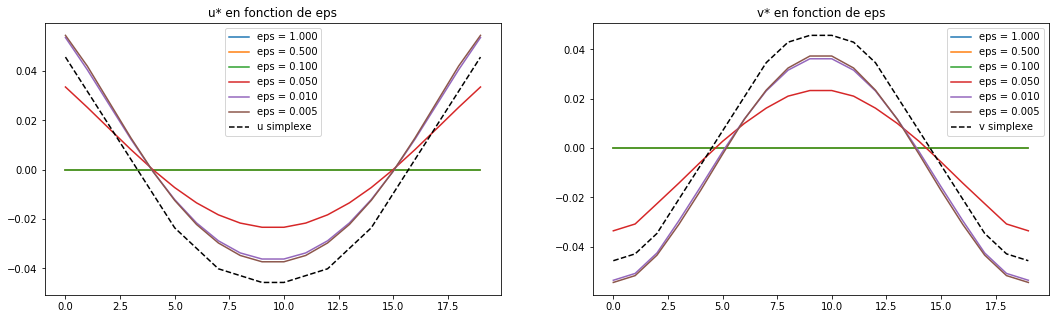

In [120]:
fig, axs = plt.subplots(1, 2, figsize=(18, 5),sharey=False)
for eps in list_eps:
    u,v = GradDualReg(mu,nu,C,eps,0.1,10**(-8),10000)
    axs[0].plot(u,label='eps = %.3f'%eps)
    axs[1].plot(v,label='eps = %.3f'%eps)
axs[0].plot(ue,'--k', label = "u simplexe")
axs[1].plot(ve,'--k', label = "v simplexe")
axs[0].set_title('u en fonction de eps')
axs[0].legend()
axs[1].set_title('v en fonction de eps')
axs[1].legend()

### 3 La régularisation entropique

**Q3.3**

In [385]:
def EntDual(mu,nu,C,eps,t,tol,iterMax):
    N=len(mu)
    uv=np.zeros(2*N)
    k=0
    gamma_= np.exp(-C/eps)
    a=np.exp(uv[:N]/eps)
    b=np.exp(uv[N:]/eps)
    d=np.concatenate((mu,nu))-np.concatenate((a,b))*np.concatenate((np.dot(gamma_.T,a),np.dot(gamma_,b)))
    while np.linalg.norm(d)>eps and k<iterMax:
        uv=uv+t*d
        a=np.exp(uv[:N]/eps)
        b=np.exp(uv[N:]/eps)
        d=np.concatenate((mu,nu))-np.concatenate((a,b))*np.concatenate((np.dot(gamma_.T,a),np.dot(gamma_,b)))
        k=k+1
    u=uv[:N]
    v=uv[N:]
    gamma=(np.kron(a,np.ones(N)) * np.kron(np.ones(N),b) * gamma_.reshape((N*N,))).reshape((N,N))
    return [u,v,gamma]

**Q3.4**

In [393]:
list_eps=[1,0.5,0.1,0.05,0.01,0.005]
N=20
x=np.linspace(0,1,N)
y=np.linspace(0,1,N)
mu=np.ones(N)/N
nu=np.exp(-10*(y-0.5)**2)
nu=nu/sum(nu)
C=np.array([(i-j)**2 for i in x for j in y]).reshape(N,N)

sol_appro1=[]
sol_appro2=[]
for eps in list_eps:
    u,v,gamma=EntDual(mu,nu,C,eps,0.001,10**(-5),20000)
    sol_appro1.append(u)
    sol_appro2.append(v)

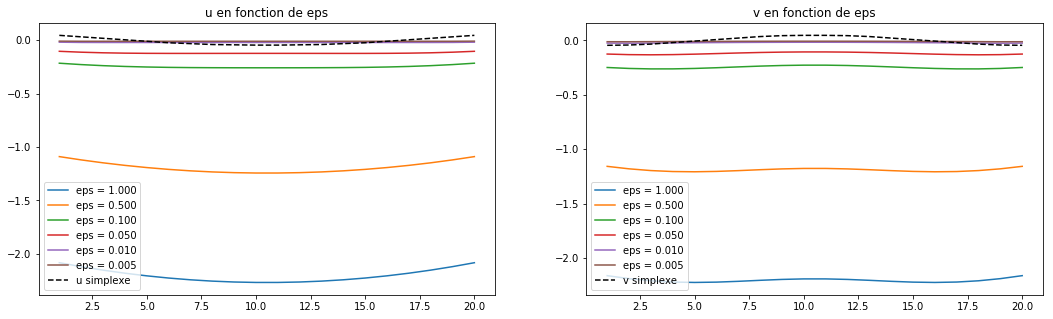

In [394]:
fig,ax=plt.subplots(1, 2, figsize=(18, 5),sharey=False)
for i in range(6):
    ax[0].plot(np.arange(1,N+1),sol_appro1[i],label='eps = %.3f'%list_eps[i])
    ax[1].plot(np.arange(1,N+1),sol_appro2[i],label='eps = %.3f'%list_eps[i])
ax[0].plot(np.arange(1,N+1),ue,'k--',label='u simplexe')
ax[1].plot(np.arange(1,N+1),ve,'k--',label='v simplexe')
ax[0].set_title('u en fonction de eps')
ax[0].legend()
ax[1].set_title('v en fonction de eps')
ax[1].legend()

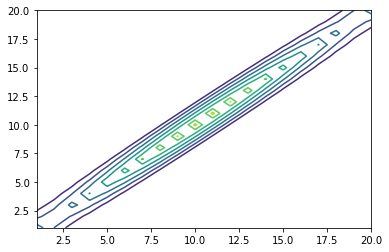

In [395]:
I,J=np.meshgrid(np.arange(1,N+1),np.arange(1,N+1))
plt.contour(I,J,gamma)

**Q3.5**

In [204]:
def Sinkhorn(mu,nu,C,eps,tol,iterMax):
    N=len(mu)
    a=np.ones(N)
    b=np.ones(N)
    k=0
    gamma_= np.exp(-C/eps)
    d=np.concatenate((mu,nu))-np.concatenate((a,b))*np.concatenate((np.dot(gamma_.T,a),np.dot(gamma_,b)))
    while np.linalg.norm(d)>tol and k<iterMax:
        a=mu/np.dot(gamma_,b)
        b=nu/np.dot(gamma_.T,a)
        d=np.concatenate((mu,nu))-np.concatenate((a,b))*np.concatenate((np.dot(gamma_.T,a),np.dot(gamma_,b)))
        k=k+1
    u=eps*np.log(a)
    v=eps*np.log(b)
    gamma=(np.kron(a,np.ones(N)) * np.kron(np.ones(N),b) * gamma_.reshape((N*N,))).reshape((N,N))
    return [u,v,gamma]

**Q3.6**

In [339]:
list_eps=[1,0.5,0.1,0.05,0.01,0.005]
N=20
x=np.linspace(0,1,N)
y=np.linspace(0,1,N)
mu=np.ones(N)/N
nu=np.exp(-10*(y-0.5)**2)
nu=nu/sum(nu)
C=np.array([(i-j)**2 for i in x for j in y]).reshape(N,N)

sol_appro1=[]
sol_appro2=[]
for eps in list_eps:
    u,v,gamma=Sinkhorn(mu,nu,C,eps,10**(-5),20000)
    sol_appro1.append(u)
    sol_appro2.append(v)

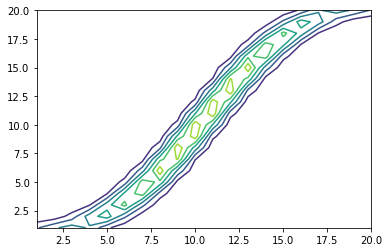

In [340]:
I,J=np.meshgrid(np.arange(1,N+1),np.arange(1,N+1))
plt.contour(I,J,gamma)

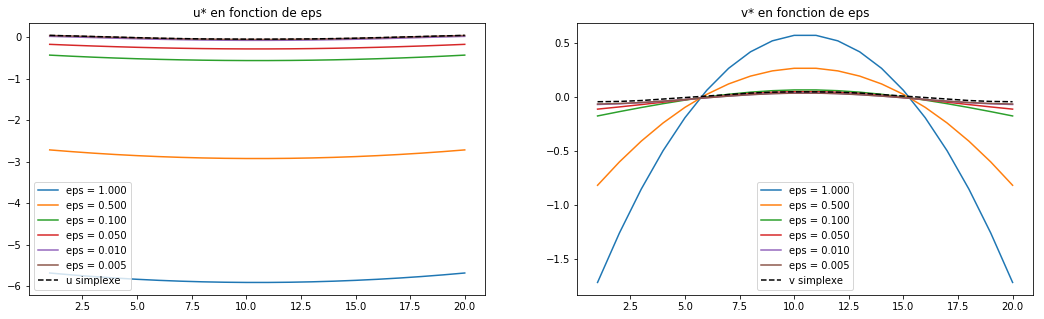

In [341]:
fig,ax=plt.subplots(1, 2, figsize=(18, 5),sharey=False)
for i in range(6):
    ax[0].plot(np.arange(1,N+1),sol_appro1[i],label='eps = %.3f'%list_eps[i])
    ax[1].plot(np.arange(1,N+1),sol_appro2[i],label='eps = %.3f'%list_eps[i])
ax[0].plot(np.arange(1,N+1),ue,'k--',label='u simplexe')
ax[1].plot(np.arange(1,N+1),ve,'k--',label='v simplexe')
ax[0].set_title('u* en fonction de eps')
ax[0].legend()
ax[1].set_title('v* en fonction de eps')
ax[1].legend()

### 4 Le transport multi-marges et l'interaction électron-électron 

**Q4.3**

In [305]:
def Sinkhorn3(rho,E,eps,tol,iterMax):
    N=len(rho)
    a=np.ones(N)
    b=np.ones(N)
    c=np.ones(N)
    k=0
    gammaTilde= np.exp(-E/eps)
    grad1=a*np.sum(b*np.dot(gammaTilde,c))
    grad2=b*np.sum(a*np.dot(gammaTilde,c))
    grad3=c*np.sum(a*np.dot(gammaTilde,b))
    d=np.concatenate((rho,rho,rho))-np.concatenate((grad1,grad2,grad3))
    while np.linalg.norm(d)>tol and k<iterMax:
        a=rho/np.array([np.sum((b*gammaTilde[i,:])*np.dot(gammaTilde,c*gammaTilde[i,:])) for i in np.arange(0,N)])
        b=rho/np.array([np.sum((a*gammaTilde[i,:])*np.dot(gammaTilde,c*gammaTilde[i,:])) for i in np.arange(0,N)])
        c=rho/np.array([np.sum((a*gammaTilde[i,:])*np.dot(gammaTilde,b*gammaTilde[i,:])) for i in np.arange(0,N)])
        grad1=a*np.array([np.sum((b*gammaTilde[i,:])*np.dot(gammaTilde,c*gammaTilde[i,:])) for i in np.arange(0,N)])
        grad2=b*np.array([np.sum((a*gammaTilde[i,:])*np.dot(gammaTilde,c*gammaTilde[i,:])) for i in np.arange(0,N)])
        grad3=c*np.array([np.sum((a*gammaTilde[i,:])*np.dot(gammaTilde,b*gammaTilde[i,:])) for i in np.arange(0,N)])
        d=np.concatenate((rho,rho,rho))-np.concatenate((grad1,grad2,grad3))
        k=k+1
    u=eps*np.log(a)
    v=eps*np.log(b)
    w=eps*np.log(c)
    gamma= np.kron(a,np.ones(N)).reshape((N,N)) * np.kron(np.ones(N),b).reshape((N,N)) * gammaTilde * np.sum(np.array([list(c*gammaTilde[i,:]*gammaTilde[j,:]) for i in np.arange(0,N) for j in np.arange(0,N)]).reshape((N,N,N)),axis=2).reshape((N,N))
    return [u,v,w,gamma]

**Q4.4**

En utilisant le coût de Coulomb

In [401]:
N=30
x=np.linspace(0,1,N)
y=np.linspace(0,1,N)
rho=np.ones(N)/N
C=np.array([2/np.abs(i-j) if i!=j else 1000 for i in x for j in y]).reshape(N,N)
gamma=solve0T(rho,rho,C)
ue,ve,s=solve0Tdual(rho,rho,C)

eps=0.011
u,v,gammaS=Sinkhorn(rho,rho,C,eps,10**(-5),20000)

Text(0.5, 1.0, 'gamma sinkhorn')

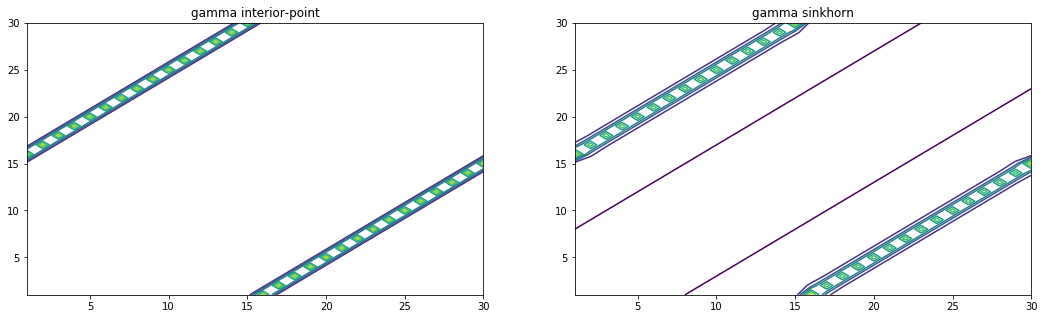

In [348]:
I,J=np.meshgrid(np.arange(1,N+1),np.arange(1,N+1))
fig,ax=plt.subplots(1, 2, figsize=(18, 5),sharey=False)
ax[0].contour(I,J,gamma.reshape((N,N)))
ax[1].contour(I,J,gammaS)
ax[0].set_title('gamma interior-point')
ax[1].set_title('gamma sinkhorn')

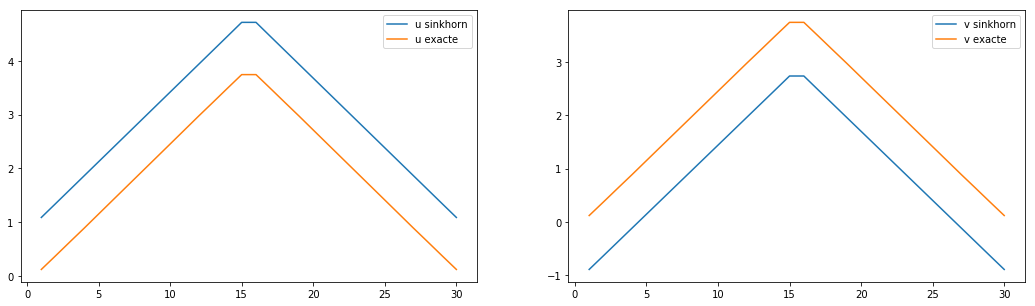

In [349]:
fig,ax=plt.subplots(1, 2, figsize=(18, 5),sharey=False)
ax[0].plot(np.arange(1,N+1),u,label='u sinkhorn')
ax[1].plot(np.arange(1,N+1),v,label='v sinkhorn')
ax[0].plot(np.arange(1,N+1),ue,label='u exacte')
ax[1].plot(np.arange(1,N+1),ve,label='v exacte')
ax[0].legend()
ax[1].legend()

En utilisant un autre coût que celui de Coulomb

In [356]:
N=30
x=np.linspace(0,1,N)
y=np.linspace(0,1,N)
rho=np.ones(N)/N
C=np.array([(i-j)**2 for i in x for j in y]).reshape(N,N)
gamma=solve0T(rho,rho,C)
ue,ve,s=solve0Tdual(rho,rho,C)

eps=0.0001
u,v,gammaS=Sinkhorn(rho,rho,C,eps,10**(-5),30000)

Text(0.5, 1.0, 'gamma sinkhorn')

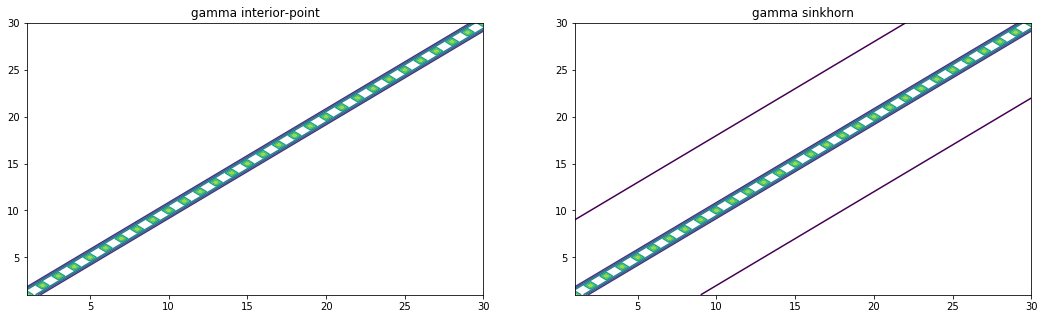

In [357]:
I,J=np.meshgrid(np.arange(1,N+1),np.arange(1,N+1))
fig,ax=plt.subplots(1, 2, figsize=(18, 5),sharey=False)
ax[0].contour(I,J,gamma.reshape((N,N)))
ax[1].contour(I,J,gammaS)
ax[0].set_title('gamma interior-point')
ax[1].set_title('gamma sinkhorn')

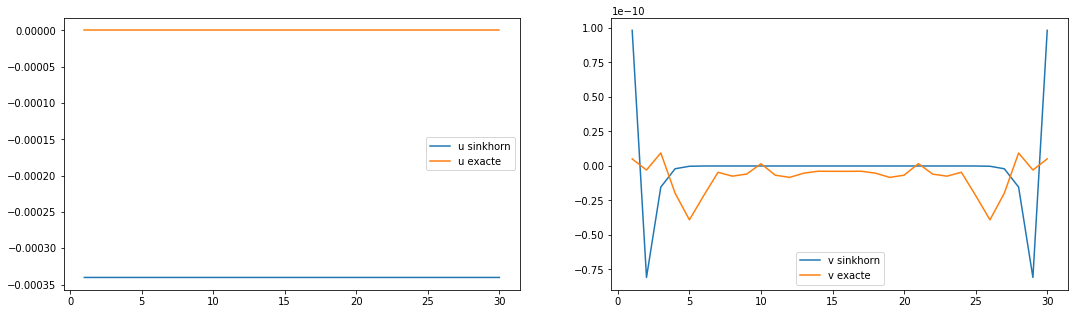

In [358]:
fig,ax=plt.subplots(1, 2, figsize=(18, 5),sharey=False)
ax[0].plot(np.arange(1,N+1),u,label='u sinkhorn')
ax[1].plot(np.arange(1,N+1),v,label='v sinkhorn')
ax[0].plot(np.arange(1,N+1),ue,label='u exacte')
ax[1].plot(np.arange(1,N+1),ve,label='v exacte')
ax[0].legend()
ax[1].legend()

**Q4.5**

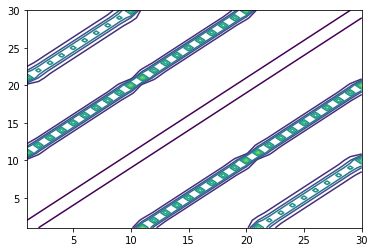

In [313]:
N=30
x=np.linspace(0,1,N)
y=np.linspace(0,1,N)
rho=np.ones(len(x))/N
C=np.array([1/np.abs(i-j) if i!=j else 1000 for i in x for j in y]).reshape(N,N)
eps=0.02
u,v,w,gamma=Sinkhorn3(rho,C,eps,10**(-5),20000)
I,J=np.meshgrid(np.arange(1,N+1),np.arange(1,N+1))
plt.contour(I,J,gamma)